# Add new features to the dataset and examine the change in performance

In [1]:
# Import needed packages
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import os
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from scipy.stats.mstats import winsorize

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Set a random state
rs = 4

#Set amount of splits
cv_split = 5

In [2]:
#Define monetary_score
def monetary_score_func(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    monetary_value = (cm[0,0] * 0) + (cm[1, 0] * -5) + (cm[0, 1] * -25) + (cm[1, 1] * 5)
    max_monetary_value = (cm[1,0] + cm[1,1]) * 5
    return (monetary_value / max_monetary_value)

monetary_score = make_scorer(monetary_score_func)

In [3]:
# get current directory 
path = os.getcwd() 

# get parent directory 
parent = os.path.dirname(path)

# move to the directory with data
train_csv = os.path.join(parent, "data", "train.csv")

#Import our dataset
dataset = pd.read_csv(train_csv, delimiter = '|')
dataset_org = dataset.copy()

#Add some new features

# add totalItems
dataset = dataset.assign(totalItems = dataset.totalScanTimeInSeconds * dataset.scannedLineItemsPerSecond)

#add avgLineItemValue
dataset = dataset.assign(avgLineItemValue = dataset.valuePerSecond / dataset.scannedLineItemsPerSecond)

#Add new feature suspicious
suspicious = dataset['trustLevel'].copy()
suspicious[suspicious > 2] = 3
dataset = dataset.assign(suspicious = suspicious)

# Outliers
dataset = dataset[dataset['scannedLineItemsPerSecond'] < 4]
cutted = len(dataset_org)-len(dataset)
print(f"{cutted} ({cutted/len(dataset_org)}) entries removed .")

# drop trustLevel because we now have suspicious 
dataset = dataset.drop('trustLevel', axis=1)

dataset['scannedLineItemsPerSecond'] = np.log(dataset['scannedLineItemsPerSecond']+1)
dataset['valuePerSecond'] = np.log(dataset['valuePerSecond']+1)
dataset['lineItemVoidsPerPosition'] = winsorize(dataset['lineItemVoidsPerPosition'], limits=[0., .1])

4 (0.0021287919105907396) entries removed .


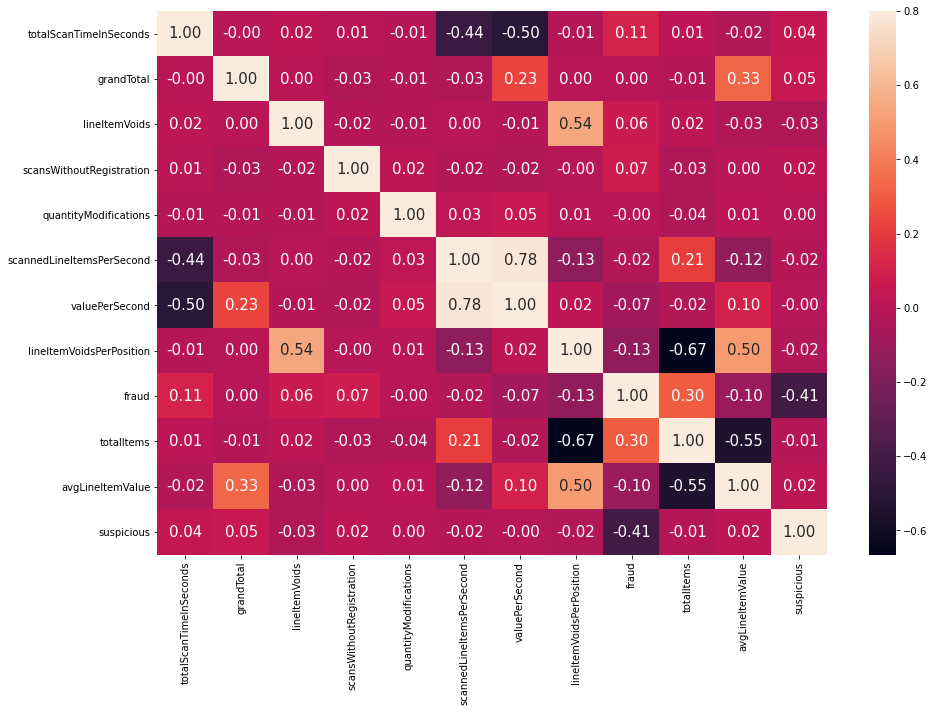

In [4]:
# look at the new correlation matrix
fig = plt.figure(figsize=(15,10))
sns.heatmap(dataset.corr(), annot=True, annot_kws={"size": 15}, vmax=0.8, fmt=".2f")

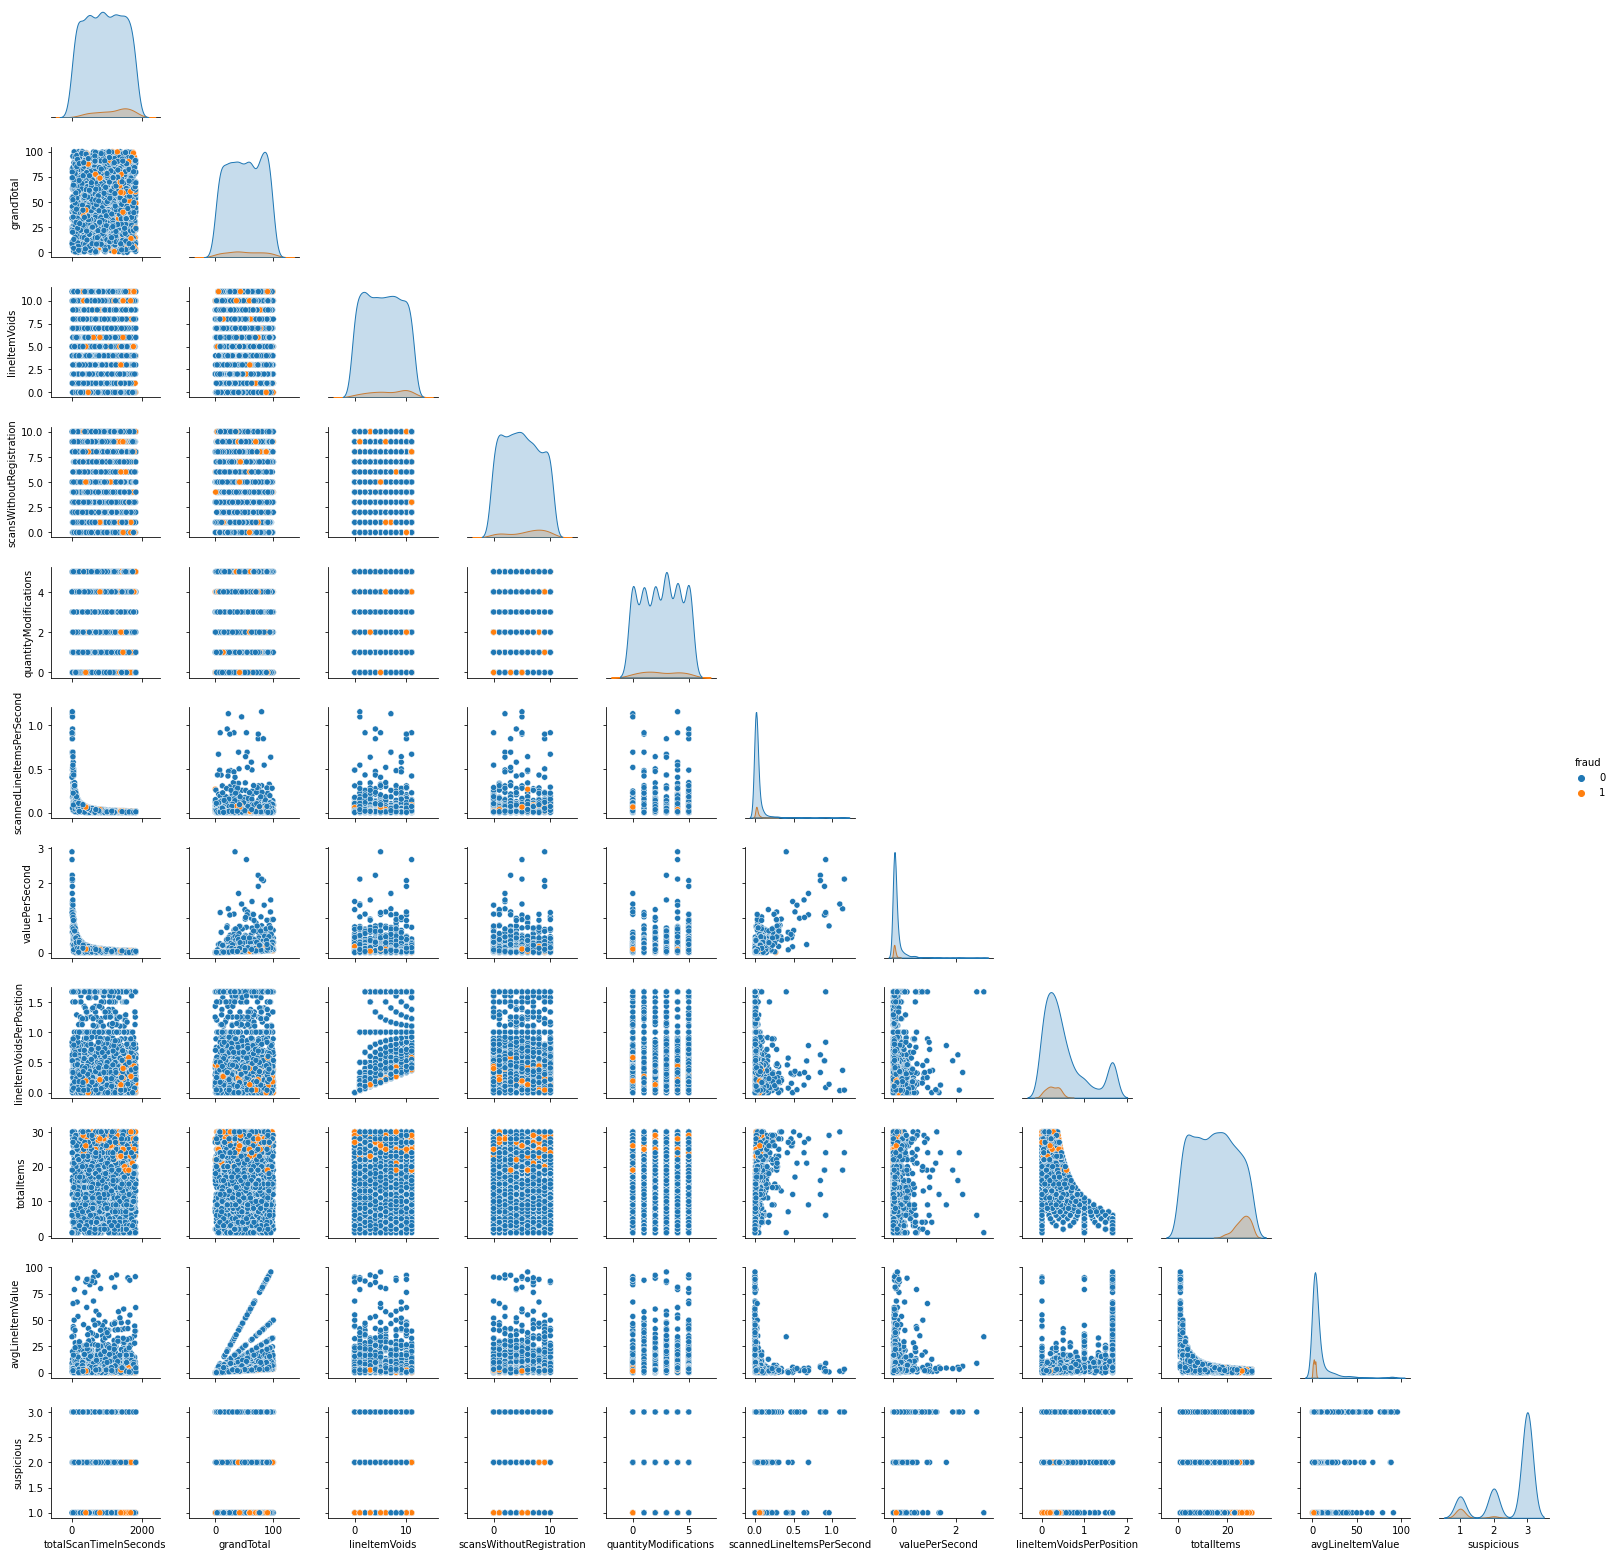

In [5]:
# look at the new pairplot including the new features
sns.pairplot(dataset, hue='fraud', corner=True, height=2)

In [6]:
#Split X and y 
X = dataset.drop('fraud', axis=1)
y = dataset.fraud

In [7]:
X

,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalItems,avgLineItemValue,suspicious
0,1054,54.70,7,0,3,0.027143,0.050596,0.241379,29.0,1.886207,3
1,108,27.36,5,2,4,0.121890,0.225807,0.357143,14.0,1.954286,3
2,1516,62.16,3,10,5,0.008539,0.040184,0.230769,13.0,4.781538,3
3,1791,92.31,8,4,4,0.016062,0.050257,0.275862,29.0,3.183103,3
4,430,81.53,3,7,2,0.060898,0.173621,0.111111,27.0,3.019630,3
...,...,...,...,...,...,...,...,...,...,...,...
1874,321,76.03,8,7,2,0.069201,0.212571,0.347826,23.0,3.305652,1
1875,397,41.89,5,5,0,0.063436,0.100313,0.192308,26.0,1.611154,1
1876,316,41.83,5,8,1,0.090697,0.124316,0.166667,30.0,1.394333,3
1877,685,62.68,1,6,2,0.034437,0.087556,0.041667,24.0,2.611667,2


In [8]:
# run the model with Crossvalidation
cv = StratifiedKFold(n_splits=cv_split, shuffle=True, random_state=rs)
   
model = SVC(kernel="linear", random_state=rs)

# create the model pipeline

pipe_model = Pipeline([    
        ("model", model)
    ])

cv_results = cross_validate(pipe_model, X, y, cv=cv_split, scoring=monetary_score, n_jobs=-1)
print("Model performance on folds:\t\t",cv_results['test_score'])
print("Model mean monetary score:\t\t", cv_results['test_score'].mean())
print("Model double standard deviation:\t", 2*cv_results['test_score'].std())

Model performance on folds:		 [0.05       0.80952381 0.76190476 0.19047619 0.47619048]
Model mean monetary score:		 0.4576190476190476
Model double standard deviation:	 0.6028533814672398


Adding the features provides a HUGE improvement for the model!!

However, we see a somewhat high standard deviation

In [9]:
### Checking the features again with permutation and SHAP 

In [10]:
# fit the model to the data to apply SHAP and Permutation importance we need the good old train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs, test_size=0.2 )

model.fit(X_train, y_train)
#Achieved score on test data
model.score(X_test, y_test)

0.992

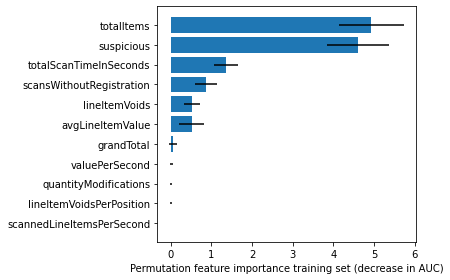

In [11]:
import eli5
from eli5.sklearn import PermutationImportance

# Feature importance based on TRAINING set

perm_test = PermutationImportance(pipe_model, scoring=monetary_score,
                                   n_iter=50, random_state=rs, cv="prefit")

# fit and see the permuation importances
perm_test.fit(X_train, y_train)

imp_df = eli5.explain_weights_df(perm_test)
label_df = pd.DataFrame({'feature': [ "x" + str(i) for i in range(len(X_test.columns))], 'feature_name': X_test.columns.values})
imp_df = pd.merge(label_df, imp_df, on='feature', how='inner', validate="one_to_one")
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='weight')
imp_range=range(1,len(imp_df.index)+1)
 

## Barplot with confidence intervals

height = ordered_df['weight']
bars = ordered_df['feature_name']
ci = 1.96 * ordered_df['std']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height, xerr=ci)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Permutation feature importance training set (decrease in AUC)")
plt.tight_layout()

# Show graphic
plt.show()

In [12]:
import shap
shap.initjs()

In [13]:
model.fit(X_train,y_train)

SVC(kernel='linear', random_state=4)

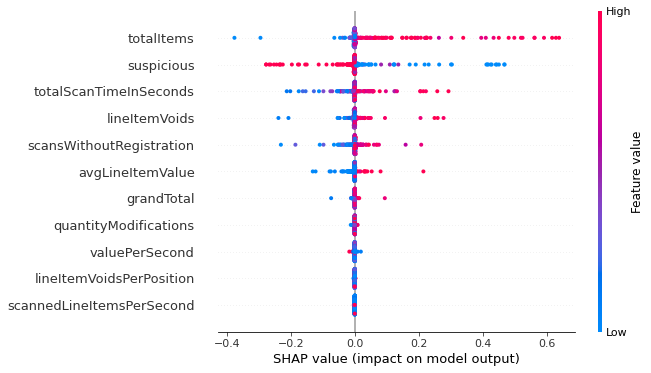

In [14]:
X_train = shap.kmeans(X_train, 50)
explainer = shap.KernelExplainer(pipe_model.predict, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

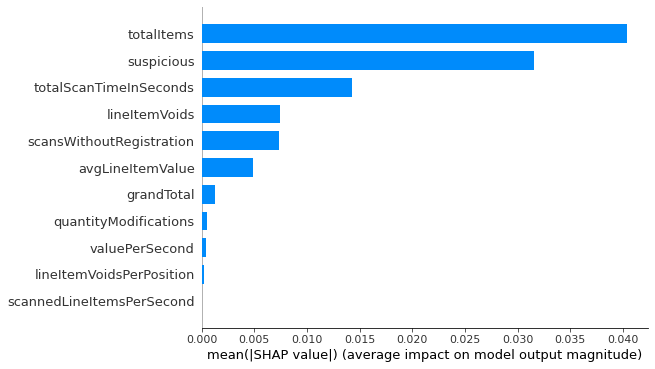

In [15]:
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, plot_type="bar")